### **Notebook to make predictions with reprocessed Yoneda and Henson data and EFLUX2 and SPOT** 

##### **Import python packages**

In [3]:
import os
import sys
import pandas as pd
import numpy as np
import cobra
#import cplex
%matplotlib inline
from matplotlib import pyplot as plt
from edd_utils import login, export_study, export_metadata

##### **Load data**

In [4]:
# Study to Download
study_slug = 'biodesign_henson2018_reprocessed'
# EDD server
edd_server = 'public-edd.jbei.org'
user       = 'schenkch'

In [5]:
session = login(edd_server=edd_server, user=user)

df = export_study(session, study_slug, edd_server=edd_server)
#df.head()

Password for schenkch:  ···············


##### **Filter transcriptomics data from all EDD data into different dataframes**

In [6]:
df_Trans = df[df['Protocol'].str.contains('Transcriptomics')]
df_Trans.head()

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours
0,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,20.0
1,14409,Biodesign_Henson2018_reprocessed,14905,WT-M-R1,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14948,WT-M-R1,NaN,WP_000104864_1,0,FPKM,0.0,32.0
2,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,20.0
3,14409,Biodesign_Henson2018_reprocessed,14906,WT-M-R2,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14949,WT-M-R2,NaN,WP_000104864_1,0,FPKM,0.0,32.0
4,14409,Biodesign_Henson2018_reprocessed,14907,WT-M-R3,R. Opacus wild type strain with Mixture of all...,Transcriptomics,14950,WT-M-R3,NaN,WP_000104864_1,0,FPKM,0.0,20.0


##### **Load Genome Scale Model**

In [7]:
file_name =  '../GSMs/Ropacus_annotated_curated_with_phenol_custom_biomass.xml'
model = cobra.io.read_sbml_model(file_name)

##### **Import EFLUX2 and SPOT Code**

In [8]:
OptlangDir = '../EFLUX2_SPOT'
sys.path.append(OptlangDir)
from ensemblemethods import EFlux2,SPOT

##### **Transform data to dataframe with just index as gene identifiers and one column for values**
##### !!!!TODO: Generalize for multiple time points


In [9]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(transdata, linename, conditionstring):
    transdataPhe = transdata[transdata['Line Description'].str.contains(conditionstring)]
    transdataWTPR1 = transdataPhe[transdataPhe['Line Name']==linename]
    transdataWTPR1new = transdataWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    transdataWTPR1new2 = transdataWTPR1new.set_index('Measurement Type')
    return transdataWTPR1new2

#### **EFLUX2 Predictions**

In [10]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2pred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2(model, transcriptdf)
        display(model.medium)
        #spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return eflux2sol#, spotsol

In [11]:
# flux2sol_WTPR1 = eflux2pred(model, df_Trans, 'WT-P-R1', 'phenol', 100, '0.5 g/l PHE as carbon source')

In [12]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2predthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    eflux2sol_R1 = eflux2pred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2 = eflux2pred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3 = eflux2pred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)
    #eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
#     #SPOT calculations:
#     spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
#     spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
#     spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
#     spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
#     #spotsol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
#     spotsol = spotsol_all.mean(axis=1)
#     spotsol_std = spotsol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std

In [13]:
eflux2sol, eflux2sol_std = eflux2predthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

FBA status optimal
FBA solution 0.43724976553939215


EFlux2 status optimal
EFlux2 solution 6142.954819768995


{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

FBA status optimal
FBA solution 0.35942486682167646


EFlux2 status optimal
EFlux2 solution 3834.139856528949


{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

FBA status optimal
FBA solution 0.4100718118882717


EFlux2 status optimal
EFlux2 solution 10161.095956689685


{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

In [14]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['stds'])
#spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
#spotsolstddf = pd.DataFrame(spotsol_std, columns=['fluxes'])

In [15]:
eflux2soldf

,fluxes
12DGR120tipp,0.000000e+00
12DGR140tipp,0.000000e+00
12DGR141tipp,0.000000e+00
12DGR161tipp,0.000000e+00
12DGR180tipp,0.000000e+00
12DGR181tipp,0.000000e+00
12PPDStpp,0.000000e+00
12PPDt,0.000000e+00
14GLUCANabcpp,0.000000e+00
14GLUCANtexi,0.000000e+00


In [16]:
exchange_list = []
for ind in eflux2soldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)
exchange_list

['EX_12ppd__S_e',
 'EX_glc__D_e',
 'EX_h2o_e',
 'EX_14glucan_e',
 'EX_h_e',
 'EX_hco3_e',
 'EX_2hxmp_e',
 'EX_2pglyc_e',
 'EX_34dhcinm_e',
 'EX_leu__L_e',
 'EX_3hoxpac_e',
 'EX_3mb_e',
 'EX_4hbz_e',
 'EX_ala__L_e',
 'EX_cl_e',
 'EX_LalaDgluMdapDala_e',
 'EX_5mtr_e',
 'EX_arab__L_e',
 'EX_4abut_e',
 'EX_acac_e',
 'EX_acald_e',
 'EX_acgam_e',
 'EX_ac_e',
 'EX_chol_e',
 'EX_acmana_e',
 'EX_acnam_e',
 'EX_pi_e',
 'EX_acser_e',
 'EX_actn__R_e',
 'EX_acysbmn_e',
 'EX_adn_e',
 'EX_ins_e',
 'EX_nh4_e',
 'EX_ad_e',
 'EX_akg_e',
 'EX_mal__L_e',
 'EX_asn__L_e',
 'EX_ala__D_e',
 'EX_gln__L_e',
 'EX_gly_e',
 'EX_ser__L_e',
 'EX_thr__L_e',
 'EX_arg__L_e',
 'EX_alltn_e',
 'EX_amp_e',
 'EX_cgly_e',
 'EX_malt_e',
 'EX_malttr_e',
 'EX_anhgm_e',
 'EX_arab__D_e',
 'EX_fe3_e',
 'EX_arbt_e',
 'EX_lys__L_e',
 'EX_orn_e',
 'EX_asp__L_e',
 'EX_aso3_e',
 'EX_aso4_e',
 'EX_k_e',
 'EX_pro__L_e',
 'EX_ala_B_e',
 'EX_cellb_e',
 'EX_meoh_e',
 'EX_madg_e',
 'EX_mbdg_e',
 'EX_bmn_e',
 'EX_buts_e',
 'EX_butso3_e',
 'EX

In [17]:
eflux2soldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(eflux2soldf.loc[i,:].values)>=0.0001:
        display(eflux2soldf.loc[i,:])
#display(eflux2soldf.loc['EX_phenol_e',:])
    

fluxes    15.261482
Name: EX_h2o_e, dtype: float64

fluxes    1.864641
Name: EX_h_e, dtype: float64

fluxes   -0.002033
Name: EX_cl_e, dtype: float64

fluxes   -0.845827
Name: EX_pi_e, dtype: float64

fluxes   -2.625001
Name: EX_nh4_e, dtype: float64

fluxes   -0.003049
Name: EX_fe3_e, dtype: float64

fluxes   -0.076227
Name: EX_k_e, dtype: float64

fluxes   -0.002033
Name: EX_ca2_e, dtype: float64

fluxes   -0.003388
Name: EX_mg2_e, dtype: float64

fluxes   -0.00027
Name: EX_mn2_e, dtype: float64

fluxes   -0.000133
Name: EX_zn2_e, dtype: float64

fluxes    25.003678
Name: EX_co2_e, dtype: float64

fluxes   -0.000277
Name: EX_cu2_e, dtype: float64

fluxes   -31.303435
Name: EX_o2_e, dtype: float64

fluxes   -0.002622
Name: EX_fe2_e, dtype: float64

fluxes   -0.022649
Name: EX_so4_e, dtype: float64

fluxes   -6.246863
Name: EX_phenol_e, dtype: float64

##### **Check FBA solution**

In [18]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.23577895481228953


##### **Load 13cdata**

#####  **Get 13C MFA measured fluxes for phenol**

In [19]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 29 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648


#### **Plot solutions: Comparison of EFLUX2 predictions and 13c measurements**

##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [20]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]
def get_std_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.stds[reaction_id]
    else:
        return solution.stds[reaction_id]

In [21]:
def scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method):
    scalepred_stds = pd.DataFrame(index=stdpredictions.index, columns= ['stds'])
    if substrate == 'phenol':
        phenoluptakerow = observed_fluxes[observed_fluxes['Pathway']=='Phenol Uptake']
        sourceuptake = float(phenoluptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_phenol_e']))
    elif substrate == 'glucose':
        glucoseuptakerow = observed_fluxes[observed_fluxes['Pathway']=='Glucose Uptake']
        sourceuptake = float(glucoseuptakerow['Flux'])
        scalepred_fluxes = predictions*(sourceuptake/(-1*predictions.loc['EX_glc__D_e']))
    else:
        print('Unknown Substrate')
    for ind in stdpredictions.index:
        if abs(stdpredictions.loc[ind,'stds'])<1e-5:
            scalepred_stds.loc[ind,'stds'] = stdpredictions.loc[ind,'stds']
        else:
            scalepred_stds.loc[ind,'stds'] = (stdpredictions.loc[ind,'stds']/predictions.loc[ind,'fluxes'])*scalepred_fluxes.loc[ind, 'fluxes']
    return scalepred_fluxes, scalepred_stds

In [22]:
def addpredfluxes_to13cdf(observed_fluxes, predictions, stdpredictions, substrate, method):
    predicted_fluxes = []
    predicted_stds = []
    scalepred_fluxes, scalepred_stds = scalepredictions(observed_fluxes, predictions, stdpredictions, substrate, method)
    for _, row in phenol_fluxes.iterrows():
        reactions = row['Forward Reactions']
        flux_value_pred = 0
        std_value_pred = 0
        for x in [x.strip('() ') for x in reactions.split(' or ')]:
            and_split = [y.strip('() ') for y in x.split(' and ')]
            flux_value_pred += min([get_flux_value(v, scalepred_fluxes) for v in and_split])
            std_value_pred += min([get_std_value(v,scalepred_stds) for v in and_split])
        predicted_fluxes.append(flux_value_pred)
        predicted_stds.append(std_value_pred)

    observed_fluxes[str(method) + ' Value'] = predicted_fluxes
    observed_fluxes[str(method) + ' std Value'] = predicted_stds
    
    return observed_fluxes

In [23]:
obspred_fluxes = addpredfluxes_to13cdf(phenol_fluxes, eflux2soldf, eflux2solstddf, 'phenol', 'EFLUX2')

In [24]:
obspred_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000,100.000000,18.478483
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459,18.841474,16.836210
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800,111.153541,16.664204
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800,111.153541,16.664204
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800,108.176626,37.078274
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305,64.730853,21.672504
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536,161.722188,-7.230407
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305,155.382381,32.393598
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762,171.759317,22.409143
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648,169.003766,19.870870


### **Plot EFLUX2 vs 13C MFA**

In [25]:
def scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]

        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])

        ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes', fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

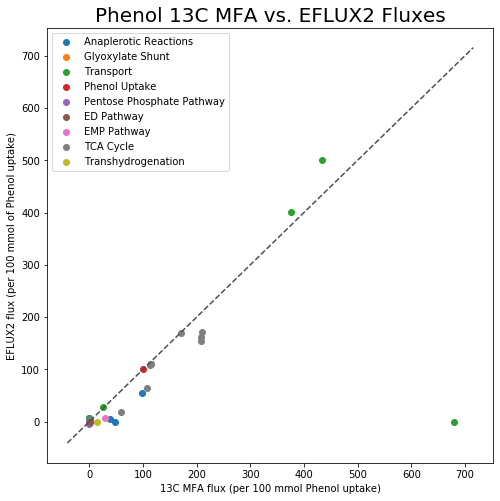

In [26]:
scatterplotcomp_obs_vs_pred(obspred_fluxes, substrate='phenol', method='EFLUX2')

### **Plot with confidence intervals**

In [27]:
import matplotlib
import matplotlib.cm as cm
def scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate, method):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

    for pathway in list(set(obspred_fluxes['Pathway'])):
        pathway_df = obspred_fluxes[obspred_fluxes['Pathway'] == pathway]
        
        measured_flux_list = list(pathway_df['Flux'])
        simulated_flux_list = list(pathway_df[str(method) + ' Value'])
        simulated_std_list = list(pathway_df[str(method) + ' std Value'])
        
        sc = ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)
        #clb = plt.colorbar(sc)
        #if pathway!='Phenol Uptake':
        ax.errorbar(
                measured_flux_list, simulated_flux_list, yerr=[1.9*std for std in simulated_std_list],
                    #fmt="ko",
            #c=.3,
                    ecolor="gray", ls='none')#,
#                         elinewidth=1,
#                         capsize=2,
#                 alpha=0.8)
        #ax.set_xlim([min(measured_flux_list), max(measured_flux_list)*1.5])
        #ax.set_xlim([pathway_df.loc[:,'Flux'].min(), pathway_df.loc[:,'Flux'].max()])
        #x_color = clb.to_rgba(measured_flux_list)
#         norm = matplotlib.colors.Normalize(vmin=min(simulated_flux_list), vmax=max(simulated_flux_list), clip=True)
#         mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
#         x_color = np.array([(mapper.to_rgba(v)) for v in simulated_flux_list])
#     for pathway,pathway2,stdpathway, color in zip(measured_flux_list, simulated_flux_list,simulated_std_list, x_color):
#         ax.errorbar(
#                 pathway, pathway2, yerr=1.96*stdpathway,
#                     fmt="ko",
#             c=.3,
#                     #ecolor="",
#                     elinewidth=1,
#                     capsize=2,
#         #capsize=2, linewidth=2.,markersize=6., mew=4., color='darkred',
#                 alpha=0.8)

    # Dashed line
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x, ls="--", c=".3")
    if substrate=='phenol':
        sub = 'Phenol'
    elif substrate=='glucose':
        sub = 'Glucose'
    else:
        print("Unknown substrate")
    plt.title(r''+str(sub)+  ' 13C MFA vs. '+ str(method) + ' Fluxes', fontSize=20)
    plt.xlabel(r'13C MFA flux (per 100 mmol '+str(sub)+  ' uptake)')
    plt.ylabel(r''+ str(method) + ' flux (per 100 mmol of '+str(sub)+  ' uptake)')
    plt.legend()
    plt.show()

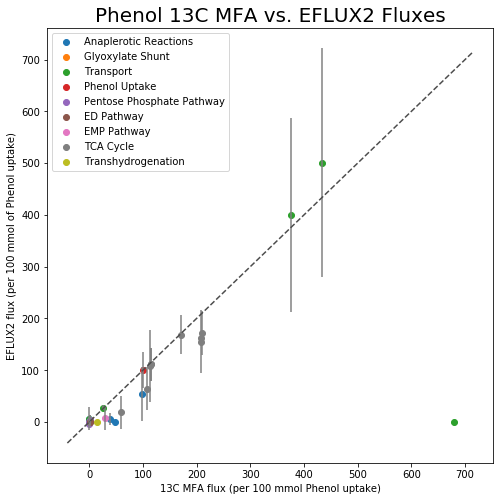

In [29]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxes, substrate='phenol', method='EFLUX2')

#### **SPOT Predictions**

In [30]:
import cplex
"""
    Creates dictionary of isozymes by parsing GPR:
    Parse GPR into a dict containing isozymes (separated by 'or'). Each isozyme has a set of subunits (separated by 'and') 'and' and 'or' can occur at the same time, or can occur by itself.
    
        Parameters
        ----------
        model : cobrapy model.
        
        
        Returns
        -------
        gpr_dict: dictionary with isozymes.
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def create_gprdict(model):   
    gpr_dict = dict()
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in rxn.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[rxn.id] = temp
    return gpr_dict

"""
    Calculates bound value based on transcriptomics data for reactions in gene reaction rule
    
    NOTE: 
    If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
    If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
    If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.Data frame has gene identifiers as index and just one column with transcript values.  
        rxn : cobrapy model reaction
        
        
        Returns
        -------
        transscript bound value: float.
"""

def findtransboundval_forgprrxns(model, Transcriptomics,rxn):
    finaltransval = 0
    for parallel_gene in create_gprdict(model)[rxn.id]:
        transvals = []
        for gene in parallel_gene:
            if gene in Transcriptomics.index:
                transvals.append(Transcriptomics.loc[gene].values)
            else:
                transvals.append(np.Inf)
            mintransval=np.min(transvals)
        finaltransval = finaltransval + mintransval
    return finaltransval

def SPOTTest(model, Transcriptomics):
    
    mets = [met.id for met in model.metabolites]
    rxns = [rxn.id for rxn in model.reactions]
    nrow = len(mets)
    ncol = len(rxns)

    rev_rxns = ['rev_'+rxn.id for rxn in model.reactions if rxn.reversibility]
    rev_ncol = len(rev_rxns)
    
    """Parse GPR into a dict containing isozymes (separated by 'or')
    # Each isozyme has a set of subunits (separated by 'and')
    #'and' and 'or' can occur at the same time, or can occur by itself."""
    #gpr_dict = create_gprdict(model)

    lb = [0.0 if rxn.reversibility else rxn.lower_bound for rxn in model.reactions] + [0.0 for rxn in model.reactions if rxn.reversibility]
    ub = [rxn.upper_bound for rxn in model.reactions] + [-rxn.lower_bound for rxn in model.reactions if rxn.reversibility]
        
    c = []
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
        #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
        #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
        #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
        
#             t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
#                                 else np.array([np.Inf]) for g in p])
#                         for p in create_gprdict(model)[r.id]])
            transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
            if transboundval == np.Inf:
                transboundval = 0
            c.append(transboundval)
        else:
            c.append(0.0)
    for rxn in model.reactions:
        if rxn.reversibility:
            if rxn.gene_reaction_rule:
                transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
                if transboundval == np.Inf:
                    transboundval = 0
                c.append(transboundval)
            else:
                c.append(0.0)

    SPOT = cplex.Cplex()
    SPOT.set_results_stream(None)
    SPOT.parameters.simplex.tolerances.optimality.set(1e-9)
    SPOT.parameters.simplex.tolerances.feasibility.set(1e-9)

    SPOT.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    SPOT.variables.add(obj=c, lb=lb, ub=ub, names=rxns+rev_rxns)
    for rxn in model.reactions:
        for m, v in rxn.metabolites.items():
            SPOT.linear_constraints.set_coefficients(m.id, rxn.id, v)
    for rxn in model.reactions:
        if rxn.reversibility:
            for m, v in rxn.metabolites.items():
                SPOT.linear_constraints.set_coefficients(m.id, 'rev_'+rxn.id, -v)
    SPOT.quadratic_constraints.add(quad_expr=[rxns+rev_rxns, rxns+rev_rxns, [1]*len(c)],
                                   sense='L', rhs=1.0, name='L2norm')#L indicating <=
    SPOT.objective.set_sense(SPOT.objective.sense.maximize)
    display(SPOT)
    SPOT.solve()
    SPOT_sol = SPOT.solution.get_objective_value()

    sol = type('',(),{})()
    temp = pd.Series(data=SPOT.solution.get_values(), index=rxns+rev_rxns)
    flux = temp.loc[rxns]
    flux_rev = temp.loc[rev_rxns]
    for rxn in model.reactions:
        if rxn.reversibility:
            flux.loc[rxn.id] = flux.loc[rxn.id] - flux_rev.loc['rev_'+rxn.id]
    sol = flux
    sol.objective_value = SPOT.solution.get_objective_value()
    sol.status = SPOT.solution.get_status_string()
    display(model.medium)
    
    return(sol)

In [31]:
#Function for EFLUX2 and SPOT Predictions:
def spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            medium["EX_glc__D_e"] = 0.0
            #medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium = {key:1000 for (key,value) in model.medium.items()}
            #medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        spotsol = SPOT(model, transcriptdf)
        display(model.medium)
        #spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return spotsol#, spotsol

In [32]:
# flux2sol_WTPR1 = eflux2pred(model, df_Trans, 'WT-P-R1', 'phenol', 100, '0.5 g/l PHE as carbon source')

In [33]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual spot predictions for all 3 replicates:
    transdata_R1 = constructTransdffrompred(transcriptdf, linename1, conditionstring)
    transdata_R2 = constructTransdffrompred(transcriptdf, linename2, conditionstring)
    transdata_R3 = constructTransdffrompred(transcriptdf, linename3, conditionstring)
 
    spotsol_R1 = spotpred(model, transdata_R1, linename1, substrate, sub_uptake_rate, conditionstring)
    spotsol_R2 = spotpred(model, transdata_R2, linename2, substrate, sub_uptake_rate, conditionstring)
    spotsol_R3 = spotpred(model, transdata_R3, linename3, substrate, sub_uptake_rate, conditionstring)
    #spot calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    #spotsol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    spotsol = pd.DataFrame(spotsol_all.mean(axis=1), columns=['fluxes'])
    spotsol_std = spotsol_all.std(axis=1)
    
#     #SPOT calculations:
#     spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
#     spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
#     spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
#     spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
#     #spotsol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
#     spotsol = spotsol_all.mean(axis=1)
#     spotsol_std = spotsol_all.std(axis=1)
    
    return spotsol, spotsol_std

In [ ]:
spotsol, spotsol_std = spotpredthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#spotsol, spotsol_std = spotspotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

In [ ]:
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['stds'])
#spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
#spotsolstddf = pd.DataFrame(spotsol_std, columns=['fluxes'])

In [ ]:
spotsoldf

In [110]:
exchange_list = []
for ind in spotsoldf.index:
    if 'EX_' in str(ind):
        exchange_list.append(ind)
exchange_list

['EX_12ppd__S_e',
 'EX_glc__D_e',
 'EX_h2o_e',
 'EX_14glucan_e',
 'EX_h_e',
 'EX_hco3_e',
 'EX_2hxmp_e',
 'EX_2pglyc_e',
 'EX_34dhcinm_e',
 'EX_leu__L_e',
 'EX_3hoxpac_e',
 'EX_3mb_e',
 'EX_4hbz_e',
 'EX_ala__L_e',
 'EX_cl_e',
 'EX_LalaDgluMdapDala_e',
 'EX_5mtr_e',
 'EX_arab__L_e',
 'EX_4abut_e',
 'EX_acac_e',
 'EX_acald_e',
 'EX_acgam_e',
 'EX_ac_e',
 'EX_chol_e',
 'EX_acmana_e',
 'EX_acnam_e',
 'EX_pi_e',
 'EX_acser_e',
 'EX_actn__R_e',
 'EX_acysbmn_e',
 'EX_adn_e',
 'EX_ins_e',
 'EX_nh4_e',
 'EX_ad_e',
 'EX_akg_e',
 'EX_mal__L_e',
 'EX_asn__L_e',
 'EX_ala__D_e',
 'EX_gln__L_e',
 'EX_gly_e',
 'EX_ser__L_e',
 'EX_thr__L_e',
 'EX_arg__L_e',
 'EX_alltn_e',
 'EX_amp_e',
 'EX_cgly_e',
 'EX_malt_e',
 'EX_malttr_e',
 'EX_anhgm_e',
 'EX_arab__D_e',
 'EX_fe3_e',
 'EX_arbt_e',
 'EX_lys__L_e',
 'EX_orn_e',
 'EX_asp__L_e',
 'EX_aso3_e',
 'EX_aso4_e',
 'EX_k_e',
 'EX_pro__L_e',
 'EX_ala_B_e',
 'EX_cellb_e',
 'EX_meoh_e',
 'EX_madg_e',
 'EX_mbdg_e',
 'EX_bmn_e',
 'EX_buts_e',
 'EX_butso3_e',
 'EX

In [111]:
spotsoldf.loc[exchange_list,:]
for i in exchange_list:
    if abs(spotsoldf.loc[i,:].values)>=0.0001:
        display(spotsoldf.loc[i,:])
#display(spotsoldf.loc['EX_phenol_e',:])
    

fluxes   -0.034485
Name: EX_h2o_e, dtype: float64

fluxes    0.141762
Name: EX_h_e, dtype: float64

fluxes    0.001379
Name: EX_leu__L_e, dtype: float64

fluxes    0.004107
Name: EX_acac_e, dtype: float64

fluxes    0.002868
Name: EX_acald_e, dtype: float64

fluxes   -0.003311
Name: EX_nh4_e, dtype: float64

fluxes    0.064963
Name: EX_succ_e, dtype: float64

fluxes    0.110089
Name: EX_co2_e, dtype: float64

fluxes   -0.201773
Name: EX_o2_e, dtype: float64

fluxes    0.002211
Name: EX_fum_e, dtype: float64

fluxes    0.000254
Name: EX_pdima_e, dtype: float64

fluxes    0.001951
Name: EX_val__L_e, dtype: float64

fluxes   -0.073866
Name: EX_phenol_e, dtype: float64

##### **Check FBA solution**

In [112]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = sub_uptake_rate
    model.medium = medium
    # solve FBA to calculate the maximum biomass
    boundedfba_sol = model.optimize()
    print('Unbounded FBA status', boundedfba_sol.status)
    print('Unbounded FBA solution', boundedfba_sol.objective_value)

Unbounded FBA status optimal
Unbounded FBA solution 0.23577895481228953


##### **Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe**

In [96]:
spotsolstddf

,stds
12DGR120tipp,7.148607e-08
12DGR140tipp,7.148607e-08
12DGR141tipp,7.148607e-08
12DGR161tipp,7.148607e-08
12DGR180tipp,7.148607e-08
12DGR181tipp,7.148607e-08
12PPDStpp,4.610516e-19
12PPDt,1.283154e-07
14GLUCANabcpp,0.000000e+00
14GLUCANtexi,0.000000e+00


In [97]:
obspred_fluxesnew = addpredfluxes_to13cdf(obspred_fluxes, spotsoldf, spotsolstddf, 'phenol', 'SPOT')

In [98]:
obspred_fluxesnew

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,EFLUX2 Value,EFLUX2 std Value,SPOT Value,SPOT std Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000,100.000000,18.478483,100.000000,4.719711e+01
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459,18.841475,16.836210,0.001222,1.770670e-06
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800,111.153542,16.664205,72.971228,1.743794e+01
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800,111.153542,16.664205,72.971778,1.796730e+01
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800,108.176626,37.078275,-0.005473,3.016219e+00
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305,64.730853,21.672504,-0.000915,3.124640e-07
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536,161.722189,-7.230408,96.566688,4.369577e+01
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305,155.382382,32.393599,81.594131,2.337426e+01
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762,171.759318,22.409144,78.599542,2.023640e+01
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648,169.003767,19.870871,91.816716,9.636682e+00


### Plot SPOT vs 13C MFA

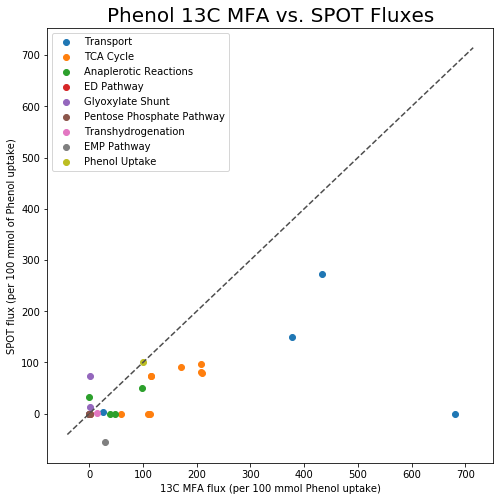

In [99]:
scatterplotcomp_obs_vs_pred(obspred_fluxesnew, substrate='phenol', method='SPOT')

In [28]:
scatterplotcomp_obs_vs_pred_withstd(obspred_fluxesnew, substrate='phenol', method='SPOT')

NameError: name 'obspred_fluxesnew' is not defined

# **For now until here!!!**

### Test SPOT in same way

In [224]:
import cplex
"""
    Creates dictionary of isozymes by parsing GPR:
    Parse GPR into a dict containing isozymes (separated by 'or'). Each isozyme has a set of subunits (separated by 'and') 'and' and 'or' can occur at the same time, or can occur by itself.
    
        Parameters
        ----------
        model : cobrapy model.
        
        
        Returns
        -------
        gpr_dict: dictionary with isozymes.
        
"""
#Code only works for GPRs written in disjunctive normal form (DNF). Majority of models have them in DNF but there are some exceptions. 

def create_gprdict(model):   
    gpr_dict = dict()
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in rxn.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[rxn.id] = temp
    return gpr_dict

"""
    Calculates bound value based on transcriptomics data for reactions in gene reaction rule
    
    NOTE: 
    If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
    If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
    If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
    
        Parameters
        ----------
        model : cobrapy model.
        Transcriptomics : pandas dataframe with transcriptomics data.Data frame has gene identifiers as index and just one column with transcript values.  
        rxn : cobrapy model reaction
        
        
        Returns
        -------
        transscript bound value: float.
"""

def findtransboundval_forgprrxns(model, Transcriptomics,rxn):
    finaltransval = 0
    for parallel_gene in create_gprdict(model)[rxn.id]:
        transvals = []
        for gene in parallel_gene:
            if gene in Transcriptomics.index:
                transvals.append(Transcriptomics.loc[gene].values)
            else:
                transvals.append(np.Inf)
            mintransval=np.min(transvals)
        finaltransval = finaltransval + mintransval
    return finaltransval

def SPOTTest(model, Transcriptomics):
    
    mets = [met.id for met in model.metabolites]
    rxns = [rxn.id for rxn in model.reactions]
    nrow = len(mets)
    ncol = len(rxns)

    rev_rxns = ['rev_'+rxn.id for rxn in model.reactions if rxn.reversibility]
    rev_ncol = len(rev_rxns)
    
    """Parse GPR into a dict containing isozymes (separated by 'or')
    # Each isozyme has a set of subunits (separated by 'and')
    #'and' and 'or' can occur at the same time, or can occur by itself."""
    #gpr_dict = create_gprdict(model)

    lb = [0.0 if rxn.reversibility else rxn.lower_bound for rxn in model.reactions] + [0.0 for rxn in model.reactions if rxn.reversibility]
    ub = [rxn.upper_bound for rxn in model.reactions] + [-rxn.lower_bound for rxn in model.reactions if rxn.reversibility]
        
    c = []
    for rxn in model.reactions:
        if rxn.gene_reaction_rule:
        #If a reaction R1 has the GPR of 'A and B', it would be parsed to { {A, B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B) ] ) = min(A, B).
        #If a reaction R1 has the GPR of 'A or B', it would be parsed to { {A}, {B} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A), min(B) ] ) = sum( [A, B] ).
        #If a reaction R1 has the GPR of '(A and B) or (C and D)', it would be parsed to { {A, B}, {C, D} } in gpr_dict['R1']. Then t for R1 would be sum( [ min(A, B), min(C, D) ] ).
        
#             t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
#                                 else np.array([np.Inf]) for g in p])
#                         for p in create_gprdict(model)[r.id]])
            transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
            if transboundval == np.Inf:
                transboundval = 0
            c.append(transboundval)
        else:
            c.append(0.0)
    for rxn in model.reactions:
        if rxn.reversibility:
            if rxn.gene_reaction_rule:
                transboundval = findtransboundval_forgprrxns(model, Transcriptomics,rxn)
                if transboundval == np.Inf:
                    transboundval = 0
                c.append(transboundval)
            else:
                c.append(0.0)

    SPOT = cplex.Cplex()
    SPOT.set_results_stream(None)
    SPOT.parameters.simplex.tolerances.optimality.set(1e-9)
    SPOT.parameters.simplex.tolerances.feasibility.set(1e-9)

    SPOT.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    SPOT.variables.add(obj=c, lb=lb, ub=ub, names=rxns+rev_rxns)
    for rxn in model.reactions:
        for m, v in rxn.metabolites.items():
            SPOT.linear_constraints.set_coefficients(m.id, rxn.id, v)
    for rxn in model.reactions:
        if rxn.reversibility:
            for m, v in rxn.metabolites.items():
                SPOT.linear_constraints.set_coefficients(m.id, 'rev_'+rxn.id, -v)
    SPOT.quadratic_constraints.add(quad_expr=[rxns+rev_rxns, rxns+rev_rxns, [1]*len(c)],
                                   sense='L', rhs=1.0, name='L2norm')#L indicating <=
    SPOT.objective.set_sense(SPOT.objective.sense.maximize)
    display(SPOT)
    SPOT.solve()
    SPOT_sol = SPOT.solution.get_objective_value()

    sol = type('',(),{})()
    temp = pd.Series(data=SPOT.solution.get_values(), index=rxns+rev_rxns)
    flux = temp.loc[rxns]
    flux_rev = temp.loc[rev_rxns]
    for rxn in model.reactions:
        if rxn.reversibility:
            flux.loc[rxn.id] = flux.loc[rxn.id] - flux_rev.loc['rev_'+rxn.id]
    sol = flux
    sol.objective_value = SPOT.solution.get_objective_value()
    sol.status = SPOT.solution.get_status_string()
    display(model.medium)
    
    return(sol)

In [225]:
df_TransPhe = df_Trans[df_Trans['Line Description'].str.contains('0.5 g/l PHE as carbon source')]
df_TransPhe
df_TransWTPR1 = df_TransPhe[df_TransPhe['Line Name']=='WT-P-R1']
df_TransWTPR1
df_TransWTPR1new=df_TransWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
df_TransWTPR1new
df_TransWTPR1new2 = df_TransWTPR1new.set_index('Measurement Type')
df_TransWTPR1new2

,Value
Measurement Type,
WP_000104864_1,0.00000
WP_000516288_1,0.00000
WP_000538659_1,0.00000
WP_001245922_1,0.00000
WP_001297013_1,0.08791
WP_001564525_1,0.00000
WP_002310911_1,0.00000
WP_002670777_1,0.00000
WP_003402602_1,472.16356


In [226]:
with model:
    medium = model.medium
    model.objective = 'Growth_Phenol'
    model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
    model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
    #sub_uptake_rate = 1.76124# just copied value to test it#growthandsubstrdata.loc[index,'substrate_consumption_rate']
    medium = {key:1000 for (key,value) in model.medium.items()}
    medium["EX_glc__D_e"] = 0.0
    #medium["EX_phenol_e"] = 100.0#sub_uptake_rate
    model.medium = medium
    spotsol_WTPR1 = SPOTTest(model, df_TransWTPR1new2)
    
    #display(df_TransWTPR1new2)
    #spotsolWTPR1 = SPOT(model, df_TransWTPR1)
    #display(spotsolWTPR1)
#         else:
# #             model.objective = 'Growth_Glucose'
#             model.objective = 'Growth'
#             sub_uptake_rate = 1.76124#growthandsubstrdata.loc[index,'substrate_consumption_rate']
#             medium["EX_glc__D_e"] = sub_uptake_rate
#             medium["EX_phenol_e"] = 0.0
#             #print(index)
#             #print(index)
#         model.medium = medium

{'EX_h2o_e': 1000,
 'EX_h_e': 1000,
 'EX_cl_e': 1000,
 'EX_pi_e': 1000,
 'EX_nh4_e': 1000,
 'EX_fe3_e': 1000,
 'EX_k_e': 1000,
 'EX_ca2_e': 1000,
 'EX_mg2_e': 1000,
 'EX_mn2_e': 1000,
 'EX_cobalt2_e': 1000,
 'EX_zn2_e': 1000,
 'EX_cu2_e': 1000,
 'EX_o2_e': 1000,
 'EX_fe2_e': 1000,
 'EX_mobd_e': 1000,
 'EX_so4_e': 1000,
 'EX_phenol_e': 1000.0}

In [227]:
spotsol_WTPR1_df = pd.DataFrame(spotsol_WTPR1, columns=['fluxes'])

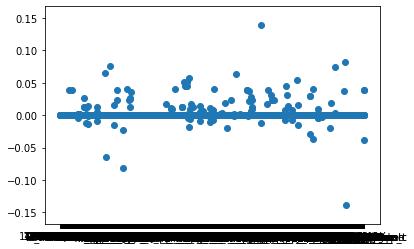

In [228]:
plt.scatter(spotsol_WTPR1_df.index,spotsol_WTPR1_df.fluxes)
plt.show()

In [229]:
spotsol_WTPR1_df
#spotsol_WTPR1_df.loc['EX_h2o_e']

,fluxes
12DGR120tipp,-2.066757e-07
12DGR140tipp,-2.066757e-07
12DGR141tipp,-2.066757e-07
12DGR161tipp,-2.066757e-07
12DGR180tipp,-2.066757e-07
12DGR181tipp,-2.066757e-07
12PPDStpp,4.336809e-19
12PPDt,3.980417e-07
14GLUCANabcpp,0.000000e+00
14GLUCANtexi,0.000000e+00


##### Just linear scale up to solution to see how it compares:

In [230]:
testscalespot = spotsol_WTPR1_df*(100/abs(spotsol_WTPR1_df.loc['EX_phenol_e']))

In [232]:
# plt.scatter(testscalespot.index,testscalespot.fluxes)
# plt.show()

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [233]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

There are 29 fluxes that can be compared between the MFA and FBA


,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648


### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [234]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [235]:
#EFLUX2_fluxes = []
SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    #flux_value_eflux2 = 0
    flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        #flux_value_eflux2 += min([get_flux_value(v, testscalespot) for v in and_split])
        flux_value_spot += min([get_flux_value(v,testscalespot) for v in and_split])
    #EFLUX2_fluxes.append(flux_value_eflux2)
    SPOT_fluxes.append(flux_value_spot)
    
#phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

,Pathway,Forward Reactions,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,SPOT Value
0,Phenol Uptake,PHEMOX,Phenol.ext -> AcCoA + SucCoA,1.000000e+02,1.000000e+02,100.0000,100.000000
1,TCA Cycle,PDH,Pyr <-> AcCoA + CO2 + NADH,5.923270e+01,5.668260e+01,62.0459,0.007659
2,TCA Cycle,CS or reverse_CITL,OAC + AcCoA -> Cit,1.144391e+02,1.102766e+02,118.4800,103.095847
3,TCA Cycle,ACONT or ( ACONTa and ACONTb),Cit -> ICit,1.144391e+02,1.102766e+02,118.4800,103.096877
4,TCA Cycle,ICDHx or ICDHyr,ICit -> AKG + CO2 + NADPH,1.134677e+02,1.068011e+02,118.4800,-0.003473
5,TCA Cycle,AKGDH or OOR3r,AKG -> SucCoA + CO2 + NADH,1.086053e+02,1.017297e+02,113.8305,-0.001101
6,TCA Cycle,3OADPCOAT or OCOAT3r or SUCBZT1 or SUCBZT2 or ...,SucCoA -> Suc + ATP,2.074789e+02,2.005620e+02,212.7536,100.015316
7,TCA Cycle,SUCDi or reverse_FRD2 or reverse_FRD3 or rever...,Suc -> Fum + FADH2,2.085767e+02,2.032666e+02,212.8305,106.131174
8,TCA Cycle,FUM,Fum -> Mal,2.096703e+02,2.043514e+02,213.8762,106.127662
9,TCA Cycle,MDH or MDH3 or MDH2 or DMALRED,Mal -> OAC + NADH,1.710231e+02,1.292999e+02,174.5648,165.323105


### Plot EFLUX2 vs 13C MFA

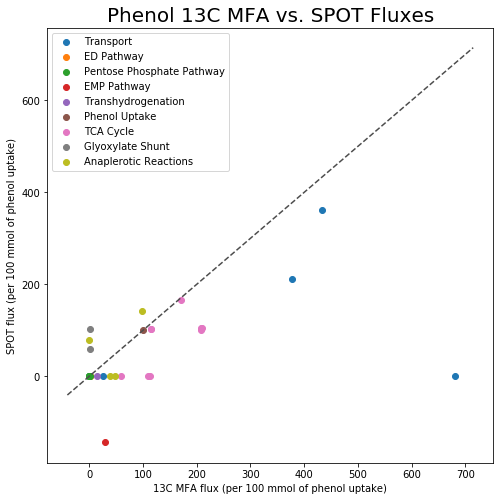

In [236]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['SPOT Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. SPOT Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'SPOT flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

In [149]:
# eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans2, 'WT-P-R1', 'phenol', 100)
# eflux2sol_WTPR2, spotsol_WTPR2 = eflux2spotpred(model, df_Trans2, 'WT-P-R2', 'phenol', 100)
# eflux2sol_WTPR3, spotsol_WTPR3 = eflux2spotpred(model, df_Trans2, 'WT-P-R3', 'phenol', 100)

In [150]:
# eflux2sol_WTPR1.fluxes

In [151]:
# eflux2sol_WTPR1_df = pd.DataFrame(eflux2sol_WTPR1.fluxes, columns=['fluxes'])
# eflux2sol_WTPR2_df = pd.DataFrame(eflux2sol_WTPR2.fluxes, columns=['fluxes'])
# eflux2sol_WTPR3_df = pd.DataFrame(eflux2sol_WTPR3.fluxes, columns=['fluxes'])
# eflux2sol_WTPR = pd.concat([eflux2sol_WTPR1_df, eflux2sol_WTPR2_df, eflux2sol_WTPR3_df], axis=1)
# eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
# eflux2sol_WTPR.mean(axis=1)
# eflux2sol_WTPR.std(axis=1)


In [152]:
# eflux2sol_WTPR

In [ ]:
# mets = [m.id for m in model.metabolites]
# rxns = [r.id for r in model.reactions]
# nrow = len(mets)
# ncol = len(rxns)
# print(nrow, ncol)

In [ ]:
# c = [r.objective_coefficient for r in model.reactions]
# S = cobra.util.create_stoichiometric_matrix(model, array_type='DataFrame')

In [ ]:
# gpr_dict = dict()
# for r in model.reactions:
#     if r.gene_reaction_rule:
#         temp = set()
#         for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
#             temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
#         gpr_dict[r.id] = temp

## E-Flux2

### Set non-zero lower and upper bounds to 0.0 or +/-Inf

In [ ]:
# for r in model.reactions:
#     if r.lower_bound < 0.0 and r.lower_bound > -1000.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.lower_bound = -1000.0
#     elif r.lower_bound > 0.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.lower_bound = 0.0
#     elif r.upper_bound > 0.0 and r.upper_bound < 1000.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.upper_bound = 1000.0
#     elif r.upper_bound < 0.0:
#         print(r.id, r.lower_bound, r.upper_bound)
#         r.upper_bound = 0.0

In [ ]:
# for r in model.reactions:
#     if r.lower_bound == -1000.0:
#         r.lower_bound = -np.Inf
#     if r.upper_bound == 1000.0:
#         r.upper_bound = np.Inf

### Load transcriptomics data and calculate lower and upper bounds

In [ ]:
# lb = []
# ub = []
# for r in model.reactions:
#     if r.gene_reaction_rule:
#         t = np.sum([np.min([df_Trans2.loc[g].values if g in df_Trans2.index 
#                             else np.array([np.Inf]) for g in p])
#                     for p in gpr_dict[r.id]])
#         if r.lower_bound < 0.0:
#             lb.append(-t)
#         else:
#             lb.append(r.lower_bound)
#         if r.upper_bound > 0.0:
#             ub.append(t)
#         else:
#             ub.append(r.upper_bound)
#     else:
#         lb.append(r.lower_bound)
#         ub.append(r.upper_bound)

### Build a CPLEX model of E-Flux2 and solve

In [ ]:
# EFlux2 = cplex.Cplex()
# EFlux2.parameters.simplex.tolerances.optimality.set(1e-9)
# EFlux2.parameters.simplex.tolerances.feasibility.set(1e-9)

# EFlux2.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
# EFlux2.variables.add(obj=c, lb=lb, ub=ub, names=rxns)
# for r in model.reactions:
#     for m, v in r.metabolites.items():
#         EFlux2.linear_constraints.set_coefficients(m.id, r.id, v)
        
# EFlux2.objective.set_sense(EFlux2.objective.sense.maximize)
# EFlux2.solve()
# EFlux2_sol = EFlux2.solution.get_objective_value()
# print
# print(EFlux2.solution.get_status_string())
# print(EFlux2_sol)

### Build a CPLEX model to minimize L2 norm and solve

In [ ]:
# Q = [1.0 for r in model.reactions]

In [ ]:
# EFlux2_min = cplex.Cplex()
# EFlux2_min.parameters.simplex.tolerances.optimality.set(1e-9)
# EFlux2_min.parameters.simplex.tolerances.feasibility.set(1e-9)

# EFlux2_min.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
# EFlux2_min.variables.add(obj=[0]*ncol, lb=lb, ub=ub, names=rxns)
# for r in model.reactions:
#     for m, v in r.metabolites.items():
#         EFlux2_min.linear_constraints.set_coefficients(m.id, r.id, v)

# EFlux2_min.variables.set_lower_bounds('Growth_Phenol', 1.0*EFlux2_sol)
# EFlux2_min.objective.set_quadratic(Q)
# EFlux2_min.objective.set_sense(EFlux2_min.objective.sense.minimize)
# EFlux2_min.solve()
# EFlux2_min_sol = EFlux2_min.solution.get_objective_value()
# EFlux2_min.solution.get_status_string()

In [ ]:
#EFlux2_min.solution.get_values()

##### **Modularized way**

In [ ]:
#Function to construct df from EFLUX2 and SPOT functions: Needs to be modified for multiple time points!!!!!
def constructTransdffrompred(df_Trans, linename, conditionstring):
    df_TransPhe = df_Trans[df_Trans['Line Description'].str.contains(conditionstring)]
    df_TransWTPR1 = df_TransPhe[df_TransPhe['Line Name']==linename]
    df_TransWTPR1new=df_TransWTPR1.filter(['Value', 'Measurement Type'])#pd.DataFrame(data=df_TransWTPR1.loc[:,'Value'], index=df_TransWTPR1['Measurement Type'])
    df_TransWTPR1new2 = df_TransWTPR1new.set_index('Measurement Type')
    return df_TransWTPR1new2

In [ ]:
constructTransdffrompred(df_Trans, linename='WT-P-R1', conditionstring='0.5 g/l PHE as carbon source')

In [ ]:
#Function for EFLUX2 and SPOT Predictions:
def eflux2spotpred(model, transcriptdf, linename, substrate, sub_uptake_rate, conditionstring):    
    with model:
        medium = model.medium
        if substrate=='phenol':
            model.objective = 'Growth_Phenol'
            model.reactions.get_by_id('Growth_Glucose').upper_bound = 0
            model.reactions.get_by_id('Growth_Glucose').lower_bound = 0
            medium["EX_glc__D_e"] = 0.0
            medium["EX_phenol_e"] = sub_uptake_rate
        elif substrate=='glucose':
            model.objective = 'Growth_Glucose'
            model.reactions.get_by_id('Growth_Phenol').upper_bound = 0
            model.reactions.get_by_id('Growth_Phenol').lower_bound = 0
            medium["EX_glc__D_e"] = sub_uptake_rate
            medium["EX_phenol_e"] = 0.0
        else:
            print('Unknown substrate: Please choose among phenol and glucose')
        model.medium = medium
        eflux2sol = EFlux2test(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
        spotsol = SPOT(model, constructTransdffrompred(transcriptdf, linename, conditionstring))
    return eflux2sol, spotsol

In [ ]:
eflux2sol_WTPR1, spotsol_WTPR1 = eflux2spotpred(model, df_Trans, 'WT-P-R1', 'phenol', 100, '0.5 g/l PHE as carbon source')

In [ ]:
#display(eflux2sol_WTPR1.fluxes['Growth_Phenol'])

In [ ]:
#spotsol_WTPR1df =pd.DataFrame(spotsol_WTPR1, columns=['fluxes'])
#spotsol_WTPR1df

In [ ]:
#Function for predictions for three replicates and averaging the solutions and calculating the standard deviation:
def eflux2spotpredthreereps(model, transcriptdf, linename1, linename2, linename3, substrate, sub_uptake_rate, conditionstring):
    #call prediction functions for individual EFLUX2 predictions for all 3 replicates:
    eflux2sol_R1, spotsol_R1 = eflux2spotpred(model, transcriptdf, linename1, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R2, spotsol_R2 = eflux2spotpred(model, transcriptdf, linename2, substrate, sub_uptake_rate, conditionstring)
    eflux2sol_R3, spotsol_R3 = eflux2spotpred(model, transcriptdf, linename3, substrate, sub_uptake_rate, conditionstring)
    #EFLUX2 calculations:
    eflux2sol_R1_df = pd.DataFrame(eflux2sol_R1.fluxes, columns=['fluxes'])
    eflux2sol_R2_df = pd.DataFrame(eflux2sol_R2.fluxes, columns=['fluxes'])
    eflux2sol_R3_df = pd.DataFrame(eflux2sol_R3.fluxes, columns=['fluxes'])
    eflux2sol_all = pd.concat([eflux2sol_R1_df, eflux2sol_R2_df, eflux2sol_R3_df], axis=1)
    #eflux2sol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    eflux2sol = pd.DataFrame(eflux2sol_all.mean(axis=1), columns=['fluxes'])
    eflux2sol_std = eflux2sol_all.std(axis=1)
    
    #SPOT calculations:
    spotsol_R1_df = pd.DataFrame(spotsol_R1, columns=['fluxes'])
    spotsol_R2_df = pd.DataFrame(spotsol_R2, columns=['fluxes'])
    spotsol_R3_df = pd.DataFrame(spotsol_R3, columns=['fluxes'])
    spotsol_all = pd.concat([spotsol_R1_df, spotsol_R2_df, spotsol_R3_df], axis=1)
    #spotsol_WTPR.rename(columns = {'fluxes':'R1', 'fluxes':'R2','fluxes':'R3'}, inplace=False)
    spotsol = spotsol_all.mean(axis=1)
    spotsol_std = spotsol_all.std(axis=1)
    
    return eflux2sol, eflux2sol_std, spotsol, spotsol_std

In [ ]:
eflux2sol, eflux2sol_std, spotsol, spotsol_std = eflux2spotpredthreereps(model, df_Trans, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100, '0.5 g/l PHE as carbon source')#eflux2sol, eflux2sol_std = eflux2spotpredthreereps(model, df_Trans2, 'WT-P-R1', 'WT-P-R2','WT-P-R3', 'phenol', 100)

In [ ]:
eflux2soldf = pd.DataFrame(eflux2sol, columns=['fluxes'])
eflux2solstddf = pd.DataFrame(eflux2sol_std, columns=['fluxes'])
spotsoldf = pd.DataFrame(spotsol, columns=['fluxes'])
spotsolstddf = pd.DataFrame(spotsol_std, columns=['fluxes'])

In [ ]:
eflux2soldf

#### **Plot solutions: Comparison of SPOT and EFLUX2 solution**

##### **Load 13cdata**

####  **Get 13C MFA measured fluxes for phenol**

In [ ]:
phenol_fluxes = pd.read_csv('../13C_flux_data/13C_phenol_flux_data.csv')
phenol_fluxes.dropna(inplace=True)
print(f'There are {len(phenol_fluxes)} fluxes that can be compared between the MFA and FBA')
phenol_fluxes

### Add Phenol EFLUX2 and SPOT flux values to phenol fluxes dataframe

In [ ]:
def get_flux_value(reaction_id, solution):
    if reaction_id.startswith('reverse_'):
        reaction_id = reaction_id.split('reverse_')[1]
        return -1*solution.fluxes[reaction_id]
    else:
        return solution.fluxes[reaction_id]

In [ ]:
EFLUX2_fluxes = []
SPOT_fluxes = []
for _, row in phenol_fluxes.iterrows():
    reactions = row['Forward Reactions']
    flux_value_eflux2 = 0
    flux_value_spot = 0
    for x in [x.strip('() ') for x in reactions.split(' or ')]:
        and_split = [y.strip('() ') for y in x.split(' and ')]
        flux_value_eflux2 += min([get_flux_value(v, eflux2soldf) for v in and_split])
        flux_value_spot += min([get_flux_value(v,spotsoldf) for v in and_split])
    EFLUX2_fluxes.append(flux_value_eflux2)
    SPOT_fluxes.append(flux_value_spot)
    
phenol_fluxes['EFLUX2 Value'] = EFLUX2_fluxes
phenol_fluxes['SPOT Value'] = SPOT_fluxes
phenol_fluxes

### Plot EFLUX2 vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulated_flux_list = list(pathway_df['EFLUX2 Value'])
    
    ax.scatter(measured_flux_list, simulated_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. EFLUX2 Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'EFLUX2 flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

### Plot SPOT vs 13C MFA

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")

for pathway in list(set(phenol_fluxes['Pathway'])):
    pathway_df = phenol_fluxes[phenol_fluxes['Pathway'] == pathway]
    
    measured_flux_list = list(pathway_df['Flux'])
    simulatedspot_flux_list = list(pathway_df['SPOT Value'])
    
    ax.scatter(measured_flux_list, simulatedspot_flux_list, label=pathway)


# Dashed line
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")

plt.title(r'Phenol 13C MFA vs. SPOT Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux (per 100 mmol of phenol uptake)')
plt.ylabel(r'SPOT flux (per 100 mmol of phenol uptake)')
plt.legend()
plt.show()

In [ ]:
rxns = [r.id for r in model.reactions]
# #EFlux2_fluxdict = dict(zip(rxns,EFlux2_min.solution.get_values()))
# EFlux2_fluxdict = dict(zip(rxns,eflux2solfluxes.to_numpy()))#replace previous .get_values()
# SPOT_fluxdict = dict(zip(rxns,spotsolWTPR1.to_numpy()))#replace previous .get_values()
# #display(SPOT_fluxdict)

In [ ]:
#Scatterplot of solutions
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

def maefunc(y_predict, y_actual):
    """Mean Absolute Error.
    Multioutput case included."""

    if y_actual.ndim == 1:
        return np.mean(np.abs([y_a - y_p for y_a, y_p in zip(y_actual, y_predict)]))
    else:
        return [
            np.mean(
                np.abs([y_a - y_p for y_a, y_p in zip(y_actual[:, i], y_predict[:, i])])
            )
            for i in range(y_actual.shape[1])
        ]
    
def scatterplotcompare(observed, predicted, labels, strtitle):
    fig, ax = plt.subplots(figsize=(8, 8))
    #res = stats.linregress(observed.to_numpy().astype(float), predicted.to_numpy())
    #print(res.rvalue**2)
    lims = [
                np.min([observed, predicted]),  # min of both axes
                np.max([observed, predicted]),  # max of both axes
            ]
    ax.set_xlim(lims)
    #ax.plot([0.0, 0.2], [0.0, 0.2], 'k',  c='0.55')
    # Plot Diagonal Dashed Line
    ax.plot(lims, lims, ls="--", color=".8", zorder=0)
    for i in range(0, len(observed)):
        ax.scatter(observed[i], predicted[i])
        #ax.annotate(str(labels[i]),(observed[i],predicted[i]))
    #ax.annotate("r-squared = {:.3f}".format(round(r2_score(observed, predicted))), (0, 1))
    #plt.plot(observed, res.intercept + res.slope*observed, 'k', label='fitted line')
    rss = np.sum((predicted - observed) ** 2)
    tss = np.sum((predicted - predicted.mean()) ** 2)
    r2_1 = np.round(1 - rss / tss,2)
    #display(r2_1)
    #r2 = round(r2_score(observed, predicted),2)
    mse = np.round(1/len(observed) * rss,2) 
    rmse = np.round(np.sqrt(1/len(observed) * rss),2)
    #display(rmse)
    #display(r2_score(observed, predicted))
    mae_score = np.round(maefunc(observed, predicted),2)
    plt.xlabel(r'EFLUX2')#Observed growth rates [$mmol/gDW/hr$]')
    plt.ylabel(r'SPOT')#Predicted growth rates [$mmol/gDW/hr$]')
    #plt.title(r'Growth rates: Observed vs. Predicted ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.title(r'EFLUX2 vs. SPOT ('+strtitle+'), \n' + f"$R^2$={r2_1}, MAE={mae_score}, MSE = {mse}, RMSE={rmse}", fontsize=18)
    plt.show()

In [ ]:
scatterplotcompare(eflux2soldf.to_numpy(), spotsoldf.to_numpy(), labels='', strtitle='')

In [ ]:
scatterplotcompare(eflux2soldf.loc['Growth_Phenol',:], spotsoldf.loc['Growth_Phenol',:], labels='Growth', strtitle='')